# OPTRAM

In [2]:
import os
import pandas as pd
import utm 
import folium
import re
from pathlib import Path
import geopandas as gpd
from shapely import geometry
from osgeo import gdal
import rasterio
import numpy as np
import numpy.ma as ma
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime, timedelta
import math
import rasterio as rs
from scipy import stats
import sys
import glob
import haversine as hs
from haversine import Unit
from shapely.geometry import Point
import pickle
from dask.distributed import Client
import dask.dataframe as dd
import dask

### Functions

In [3]:
def utm_to_latlon(coords, zone_number = 12, zone_letter = 'N'):
    easting = coords[0]
    northing = coords[1]
    return utm.to_latlon(easting, northing, zone_number, zone_letter)

def S2_getDate(filename) :
    basename = Path(filename).stem  
    try :
        found = re.search('S2(A|B)2A_(\d+)_.*',basename).group(2)
        dt = datetime.datetime.strptime(found, '%Y%m%d')
        
    except AttributeError:
        raise ValueError('Error: Date can not be extracted from filename %s .' % filename)
        
    return dt

# TODO unify funcs S2_get*
def S2_getSCL(BASE_DIR, date) :
    
    if (isinstance(date, datetime.date)) : 
        date_str = date.strftime("%Y%m%d")
    
    elif (isinstance(date, str)):
        print('"str" type object detected, converting to datetime.')
        date_obj = datetime.datetime.strptime(date, "%Y%m%d") 
        date_str = date_obj.strftime("%Y%m%d")
        
    else : 
        raise TypeError('Error:  %s encountered, but "str" o "datetime.date" expected' % type(date))
    
    pattern = BASE_DIR + '*' + date_str + '*'
    
    try: 
        filepath = glob.glob(pathname = pattern)
        return filepath[0]
    
    except AttributeError: 
        print('Error: File with pattern %s not found' % pattern)
        
def S2_getNDVI(BASE_DIR, date) :
    
    if (isinstance(date, datetime.date)) : 
        date_str = date.strftime("%Y%m%d")
    
    elif (isinstance(date, str)):
        print('"str" type object detected, converting to datetime.')
        date_obj = datetime.datetime.strptime(date, "%Y%m%d") 
        date_str = date_obj.strftime("%Y%m%d")
        
    else : 
        raise TypeError('Error:  %s encountered, but "str" o "datetime.date" expected' % type(date))
    
    pattern = BASE_DIR + '*' + date_str + '*'
    
    try: 
        filepath = glob.glob(pathname = pattern)
        return filepath[0]
    
    except Exception as e: 
        print('Error while reading file %s' % pattern)
        print(e)
        
def S2_get_sensing_dt(boa_fp):
    days_offset = 1
    start_dt = S2_getDate(boa_fp) - datetime.timedelta(days=days_offset)
    end_dt   = S2_getDate(boa_fp) + datetime.timedelta(days=days_offset)
    
    start_dt = start_dt.strftime('%Y-%m-%d')
    end_dt   = end_dt.strftime('%Y-%m-%d')

    now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
    print('[%s] : Requesting image metadata between %s <-> %s...' % (now, start_dt, end_dt))
    # bash callback: 
    dts = ! Rscript ./sen2r/sat_sensing_dt.R $start_dt $end_dt ./sen2r/Walnut-Gulch.geojson 2> /dev/null
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    sensing_datetime = datetime.datetime.strptime(dts[1], '                                        "%Y-%m-%d %H:%M:%S UTC" ')
    return sensing_datetime


def is_defective_px(SCL_px_val):
    
    if ((SCL_px_val == 4) | (SCL_px_val == 5)): # vegetated OR not_vegetated
        return False
    
    else : 
        return True

# Vectorized version
is_defective_px_vect = np.vectorize(is_defective_px)

# TODO: maybe in the denominator are included alpha values and thus
# computing an undervaluated percentage ?
# TODO type checks 
# TODO shape checks  
def S2_defective_px_perc(scl_raster) : 
    not_defective = sum(~np.array(is_defective_px_vect(scl_raster)))
    perc = not_defective / len(np.ndarray.flatten(scl_raster))
    return perc

def get_px_coords_from_raster(boa) :
    print('[%s] : Retrieving px location coords...' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    dataset = boa
    val = boa.read(3, masked = True)
    no_data = dataset.nodata
    geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
    coords_utm = [(point.x, point.y)  for point in geometry]
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
    return (zip(*coords_utm))

# TODO: add aditional col for sensor name
def build_inSitu_obs(df, dest_lat_lng, sensor_df, dists, sensor_name, utm_n = 12, utm_z = 'N') :
    
    # Calculate the closest image pixel to the sensor
    x = df.loc[:,'utm_x'].tolist()
    y = df.loc[:,'utm_y'].tolist()
    
    #print('[%s] : Calculating haversine distance for %d rows...'
    #      % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"), len(df)))
    #dists = [  hs.haversine(utm_to_latlon(item, utm_n, utm_Z),
    #                        dest_lat_lng, unit = Unit.METERS)
    #    
    #           for item in zip(x,y) 
    #]
    #print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    df['dist'] = dists
    df['sensor_name'] = sensor_name
    print('[%s] : Sorting %d rows...' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"), len(df)))
    df.sort_values('dist', inplace = True)
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    df = df.head(1)
    df.set_index('datetime', inplace = True)
    
    # Get the corresponding sensor obs to the pixel
    
    #https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    def nearest(items, pivot):
        return min(items, key=lambda x: abs(x - pivot))
              
    nearest_dt = nearest(items = sensor_df.index, pivot = df.index[0])
    val = sensor_df.loc[sensor_df.index == nearest_dt, 'SM5'].values
    print('nearest_dt: %s, %s'% (nearest_dt, val))
    df.loc[:,'SM5'] = val
    return df


def get_haversine_dist_df(utm_coords, sensor_coords, sensor_name, utm_n = 12, utm_z = 'N') : 
   # Calculate the closest image pixel to the sensor
    #x = sensor_df.loc[:,'utm_x'].tolist()
    #y = sensor_df.loc[:,'utm_y'].tolist()

    print('[%s] : Calculating haversine distance for sensor %s...'
          % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"), sensor_name))
    
    dists = [  hs.haversine(utm_to_latlon(utm_coord, utm_n, utm_Z),
                            sensor_coords, unit = Unit.METERS)
        
               for utm_coord in utm_coords 
    ]
    
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    return(dists)

def get_distances_pxs_to_sensor(boa_dummy, sensors_coords, utm_x, utm_y):
    #boa_fp = BASE_DIR_BOA + boa_files[0]
    #boa_dummy  = rs.open(boa_fp)
    h_dists = { sensor_name : get_haversine_dist_df(utm_coords = zip(utm_x, utm_y),
                                                    sensor_coords = sensors_coords[sensor_name],
                                                    sensor_name = sensor_name) 
                    for sensor_name, sensor_coords in sensors_coords.items()} 
    return (h_dists)

In [4]:
if False: # Do not run
    
    fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
    print(S2_getDate(fname))
    
    SCL_file = S2_getSCL(BASE_DIR, date = '20181213')  
    print(SCL_file)
    

## REGION OF STUDY


In [5]:
swrc = gpd.read_file('./WG-boundary/boundary/boundary.shp')
swrc

,MAJOR_SUBW,Shape_Leng,Shape_Area,geometry
0,1.0,78272.01636,1.477542e+08,"POLYGON ((605817.380 3515703.128, 605817.505 3..."


Plotting with Folium requires lat, long data, so we have to convert from UTM

In [6]:
# Arizona
utm_N = 12 
utm_Z = 'N'

x,y = swrc.geometry[0].exterior.coords.xy
points = []
for i in range(len(swrc.geometry[0].exterior.coords.xy[1])) : 
    points.append(utm_to_latlon(coords = [x[i], y[i]],
                                zone_number = utm_N,
                                zone_letter = utm_Z))
 

points_rev = [(y,x) for x,y in points]
swrc['geometry'] = geometry.Polygon(points_rev)

Also we want to plot the locations of ground probes: 

In [7]:
# https://www.tucson.ars.ag.gov/dap/dap_docs/soil.html


sensor_coords_utm = {'rg13vt19'  : [586110, 3510185],
                     'rg14vt19'  : [585442, 3507187],
                     #'rg18vt19'  : [586710, 3508098],
                     'rg20vt19'  : [587480, 3504939],
                     'rg28vt19'  : [590624, 3509990],
                     'rg34vt19'  : [590946, 3507458],
                     'rg37vt19'  : [593303, 3506068],
                     'rg40vt19'  : [593360, 3510286],
                     'rg46vt19'  : [595289, 3508655],
                     'rg57vt19'  : [596089, 3510781],
                     'rg69vt19'  : [603916, 3515463],
                     'rg70vt19'  : [604288, 3514207],
                     'rg76vt19'  : [582624, 3509679],
                     'rg82vt19'  : [600154, 3511680],
                     'rg83vt19'  : [589679, 3512426],
                     'rg89vt19'  : [596308, 3513931],
                     'rg92vt19'  : [581888, 3511774],
                     'rg100vt19' : [593266, 3504720]
}

sensors_coords = {s_key : utm_to_latlon(s_utm, utm_N, utm_Z) 
                  for s_key, s_utm in sensor_coords_utm.items()}

In [8]:
m = folium.Map(location = [31.713068,  -110.025442],
               zoom_start = 11,
               tiles = "CartoDB positron")

for _, r in swrc.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
    
for sensor_key, sensor_coords in sensors_coords.items():
    
    folium.Marker(sensor_coords, popup=sensor_key).add_to(m)
    m.add_child(folium.ClickForMarker(popup="Waypoint"))

m

 Shapefile to geojson conversion

In [9]:
swrc.to_crs(epsg=4326)
swrc.to_file('./sen2r/Walnut-Gulch.geojson', driver='GeoJSON')

/home/vyago/miniconda3/envs/spatial/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## LOAD DATA

### Sensor 

In [10]:
 %%time

sensor_path = "./sensor_data"
sensors_df = {}
    
if False: 
    # TODO : check existence of sensor_path folder
    names = ["site", "year", "day", "hr", "mn", "SM5", "SM15", "SM30", "SM50", "SM75", "SM100", "SM200"]
    url_base = 'https://www.tucson.ars.ag.gov/metDAP/'
    for sensor_key,_ in list(sensors_coords.items()) :
        print("Processing sensor %s" % sensor_key)
        try: 
            if 'rg' in sensor_key :

                sensors_df[sensor_key] = pd.read_csv(url_base + 'RaingageSiteData/' + sensor_key +'.out',
                                                     sep='\,', 
                                                     names = names,
                                                     engine='python')
            else :
                sensors_df[sensor_key] = pd.read_csv(url_base + 'SoilProfileSiteData/' + sensor_key +'.out',
                                                     sep='\s+', 
                                                     names = names,
                                                     engine='python')


            sensors_df[sensor_key]['datetime'] = (pd.to_datetime(sensors_df[sensor_key]['year'] * 1000 + sensors_df[sensor_key]['day'], format='%Y%j') 
                                                  +
                                                  pd.to_timedelta(sensors_df[sensor_key]["hr"], unit="h") 
                                                  +
                                                  pd.to_timedelta(sensors_df[sensor_key]["mn"], unit="min"))

            sensors_df[sensor_key].set_index('datetime', inplace=True)
            sensors_df[sensor_key].replace(6999, None, inplace=True) 
            sensors_df[sensor_key].to_parquet(os.path.join(sensor_path, sensor_key+".parquet"), engine="fastparquet")

            #print(sensors_df[sensor_key].index)


        except Exception as e :
            print("An error occurred while reading data for sensor %s " % sensor_key)
            print("Original message: %s " % e)
            del sensors_df[sensor_key]
            del sensors_coords[sensor_key]


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


In [11]:
%%time
for sensor_parquet in os.listdir(sensor_path): 
    sensors_df[os.path.splitext(sensor_parquet)[0]] = pd.read_parquet(os.path.join(sensor_path, sensor_parquet), engine="fastparquet")

CPU times: user 152 ms, sys: 11.7 ms, total: 163 ms
Wall time: 210 ms


Both rg82 & rg83 need custom processing

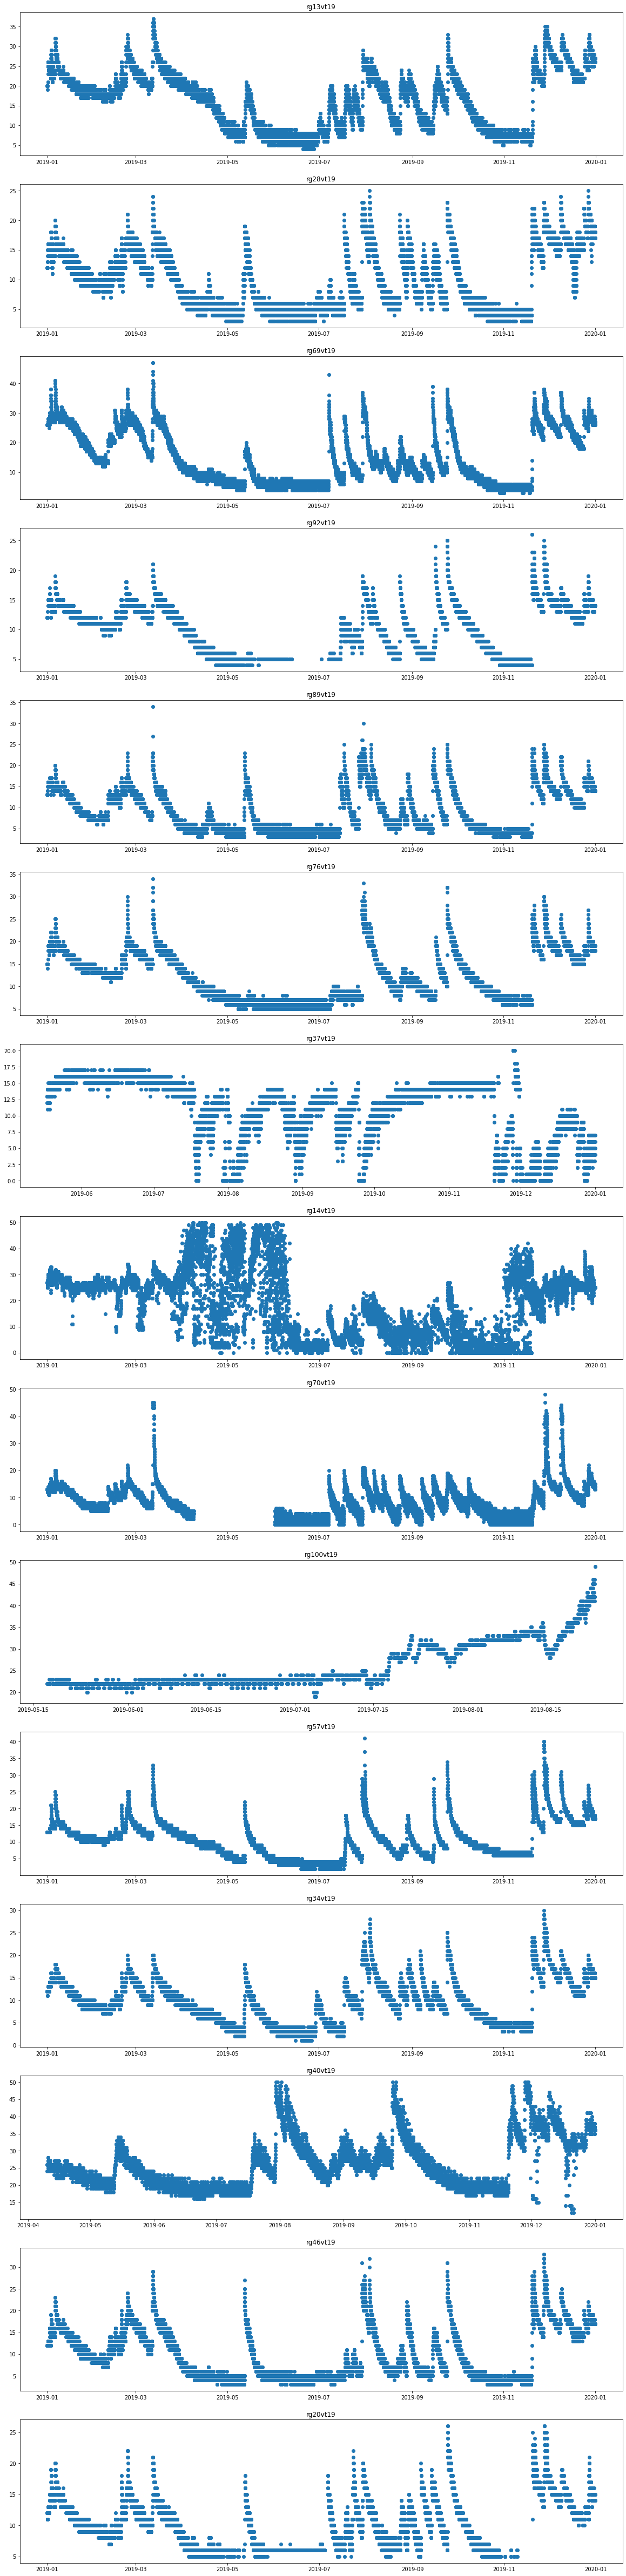

In [12]:
col_nums = 1  
row_nums = math.ceil(len(sensors_df.items()) / col_nums)
plt.figure(figsize=(20, 35))
for i, (k, df) in enumerate(sensors_df.items(), 1):
    df = sensors_df[k]
    plt.subplot(row_nums, col_nums, i)
    plt.scatter(x = df.index, y= df.loc[:,'SM5'])
    plt.title(k)
plt.subplots_adjust(left=None, bottom=None, right=None, top=2 , wspace=None, hspace=None)

### Satellite

In [13]:
BASE_DIR = './sen2r/out/'
BASE_DIR_BOA = './sen2r/out/BOA2/'
BASE_DIR_NDVI = './sen2r/indices/NDVI/'
BASE_DIR_SAT_IMG_DF = './sat_img_df/' # change name to differenciate from BASE_DIR which means to ./sen2r/dir

boa_files = [f for f in os.listdir(BASE_DIR_BOA,) if os.path.isfile(os.path.join(BASE_DIR_BOA, f))]

#inSitu_obs_dict = { sensor_name:[] for sensor_name,_ in sensors_coords.items()}

In [14]:
# ----------------------------------PRECALCULATED for speedup

if False :
    print('[%s] : ------- PRECOMPUTING  -------\n' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    boa_dummy  = rs.open(BASE_DIR_BOA + boa_files[0])
    utm_x, utm_y =  get_px_coords_from_raster(boa_dummy)

    haversine_dists = get_distances_pxs_to_sensor(boa_dummy = boa_dummy,
                                                  sensors_coords = sensors_coords,
                                                  utm_x = utm_x,
                                                  utm_y = utm_y)
    print('[%s] : ----- PRECOMPUTING DONE -----\n' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    
    with open('./haversine_dists.pkl', 'wb') as f:
        pickle.dump(haversine_dists, f)
        
with open('./haversine_dists.pkl', 'rb') as f:
    haversine_dists = pickle.load(f)

In [15]:
# TODO check folder BASE_DIR_SAT_IMG_DF exists if not create
if False : 
    for idx,file in enumerate(boa_files) : 
        try : 
            now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
            print('[%s] : processing file (%s/%s) %s... \n' % (now, idx, len(boa_files), file))

            boa_fp = BASE_DIR_BOA + file
            print(boa_fp)
            raster_date = S2_getDate(boa_fp)
            scl_fp = S2_getSCL(BASE_DIR_BOA, raster_date)
            ndvi_fp = S2_getNDVI(BASE_DIR_NDVI, raster_date)

            boa  = rs.open(boa_fp)
            scl  = rs.open(scl_fp)
            ndvi  = rs.open(ndvi_fp)

            swir = boa.read(11, masked = True)
            scl  = scl.read(1, masked = True)
            ndvi = ndvi.read(1)
            ndvi = np.ndarray.flatten(ndvi)
            ndvi = np.delete(ndvi, ndvi == -9999.0)

            swir = swir / 10000 #  #SWIR2 band 12 http://sen2r.ranghetti.info/articles/outstructure.html
            STR  = ((1-swir)**2)/(2*swir)
            STR  = np.ndarray.flatten(STR)
            STR  = np.delete(STR, STR.mask)

            # TODO : check defective_px_perc before proccess the following
            # TODO : add col defective_px {Boolean}  for further filtering

            data = {
                'datetime' : S2_get_sensing_dt(boa_fp),
                'ndvi' : ndvi,
                'str'  : STR,
                'defective_px_perc' : S2_defective_px_perc(np.ndarray.flatten(scl.data)),
                'utm_x' : utm_x, 
                'utm_y' : utm_y,
                'fpath' : boa_fp
            }

            local_df = pd.DataFrame(data)
            local_df.to_parquet(os.path.join(BASE_DIR_SAT_IMG_DF,
                                             datetime.datetime.strftime(raster_date, "%Y-%m-%d")+".parquet"),
                                engine="fastparquet")

        except Exception as e : 
            print("An error occurred while processing data for file %s " % file)
            print("Original message: %s " % e)

In [16]:
ddf = dd.read_parquet(BASE_DIR_SAT_IMG_DF+"*", engine='fastparquet')
print(ddf)

Dask DataFrame Structure:
                      datetime     ndvi      str defective_px_perc    utm_x    utm_y   fpath
npartitions=71                                                                              
                datetime64[ns]  float32  float64           float64  float64  float64  object
                           ...      ...      ...               ...      ...      ...     ...
...                        ...      ...      ...               ...      ...      ...     ...
                           ...      ...      ...               ...      ...      ...     ...
                           ...      ...      ...               ...      ...      ...     ...
Dask Name: read-parquet, 71 tasks


In [17]:
client = Client(memory_limit='12GB', processes=True,
                n_workers=6, threads_per_worker=2)


if False : 
    
    meta = pd.DataFrame({
                  'datetime':    pd.Series(dtype='datetime64[ns]'),
                  'ndvi':        pd.Series(dtype='float32'),
                  'str':         pd.Series(dtype='float64'),
                  'defective_px_perc': pd.Series(dtype='float64'),
                  'utm_x':       pd.Series(dtype='float64'),
                  'utm_y':       pd.Series(dtype='float64'),
                  'fpath':       pd.Series(dtype='object'),
                  'dist':        pd.Series(dtype='float64'),
                  'sensor_name': pd.Series(dtype='str'),
                  'SM5':         pd.Series(dtype='float64')
    })
    meta.set_index("datetime", inplace=True)

    inSitu_obs_dfs_list = list()
    for sensor_name, sensor_coords in sensors_coords.items() :
        try : 
            inSitu_obs_df = ddf.map_partitions(build_inSitu_obs, 
                                               dest_lat_lng  = sensors_coords[sensor_name],
                                               sensor_df     = sensors_df[sensor_name],
                                               dists         = haversine_dists[sensor_name],
                                               sensor_name   = sensor_name,
                                               meta =  meta)

            inSitu_obs_dfs_list.append(inSitu_obs_df)

        except Exception as e : 
            print("An error occurred while processing data for sensor %s " % sensor_name)
            print("Original message: %s " % e)

        inSitu_dfs = [inSitu_obs_df.compute() for inSitu_obs_df in inSitu_obs_dfs_list]
        with open('./inSitu_dfs.pkl', 'wb') as f:
            pickle.dump(inSitu_dfs, f)   
    client.close()

with open('./inSitu_dfs.pkl', 'rb') as f:
    inSitu_dfs = pickle.load(f)
inSitu_dfs_global = pd.concat(inSitu_dfs)

In [18]:
inSitu_dfs_global

,ndvi,str,defective_px_perc,utm_x,utm_y,fpath,dist,sensor_name,SM5
datetime,,,,,,,,,
2019-01-05 18:07:31,0.025641,1.229045,0.000000,586115.0,3510185.0,./sen2r/out/BOA2/S2A2A_20190105_041_Walnut-Gul...,4.991329,rg13vt19,24.0
2019-01-10 18:07:29,0.002371,1.230729,0.000000,586115.0,3510185.0,./sen2r/out/BOA2/S2B2A_20190110_041_Walnut-Gul...,4.991329,rg13vt19,24.0
2019-01-20 18:06:49,0.137255,1.131776,0.000561,586115.0,3510185.0,./sen2r/out/BOA2/S2B2A_20190120_041_Walnut-Gul...,4.991329,rg13vt19,20.0
2019-01-25 18:06:31,0.120135,1.295199,0.000044,586115.0,3510185.0,./sen2r/out/BOA2/S2A2A_20190125_041_Walnut-Gul...,4.991329,rg13vt19,19.0
2019-01-30 18:06:09,0.125749,1.614491,0.000090,586115.0,3510185.0,./sen2r/out/BOA2/S2B2A_20190130_041_Walnut-Gul...,4.991329,rg13vt19,19.0
...,...,...,...,...,...,...,...,...,...
2019-12-11 18:07:41,0.116239,1.415687,0.000000,593265.0,3504715.0,./sen2r/out/BOA2/S2A2A_20191211_041_Walnut-Gul...,5.113913,rg100vt19,NaN
2019-12-16 18:07:39,0.240483,1.741353,0.000107,593265.0,3504715.0,./sen2r/out/BOA2/S2B2A_20191216_041_Walnut-Gul...,5.113913,rg100vt19,NaN
2019-12-21 18:07:41,0.223140,1.500133,0.000000,593265.0,3504715.0,./sen2r/out/BOA2/S2A2A_20191221_041_Walnut-Gul...,5.113913,rg100vt19,NaN


In [19]:
df_global = ddf[["str", "ndvi"]].compute()
df_global

,str,ndvi
0,1.706716,0.046218
1,1.706716,0.045296
2,1.706716,0.057519
3,1.706716,0.057221
4,1.694953,0.048370
...,...,...
1477545,1.851456,0.256545
1477546,1.851456,0.238468
1477547,2.007818,0.262622
1477548,1.955767,0.257143


In [27]:
df_global_sliced = df_global[1:10000000] # problems plotting huge amount

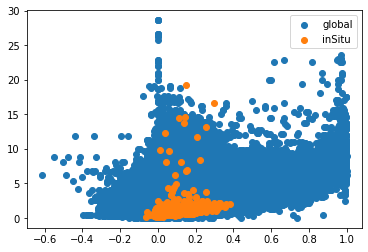

In [28]:
plt.scatter(df_global_sliced.loc[:,'ndvi'], df_global_sliced.loc[:,'str'], label = "global")
plt.scatter(inSitu_dfs_global.loc[:,'ndvi'], inSitu_dfs_global.loc[:,'str'], label = 'inSitu')
plt.legend()
plt.show()

# OPTRAM FIT

In [ ]:
def W(STRd, STRw, STR):
    return((STR - STRd)/(STRw - STRd))

def STRd_f(intercept, slope, ndvi):
    return (intercept + slope*ndvi) 

def STRw_f(intercept, slope, ndvi):
    return (intercept + slope*ndvi)

In [ ]:
edge_dry_intercept = -0.2
edge_dry_slope = 2.3

edge_wet_intercept = 1.8 
edge_wet_slope = 4

plt.scatter(global_df.loc[:,'ndvi'], global_df.loc[:,'str'])
plt.scatter(inSitu_df.loc[:,'ndvi'], inSitu_df.loc[:,'str'], label = 'inSitu')
plt.axline((0, edge_dry_intercept), slope=edge_dry_slope, color='red', label='dry')
plt.axline((0, edge_wet_intercept), slope=edge_wet_slope, color='blue', label='edge')
plt.legend()
plt.show()

In [ ]:
str_d =  STRd_f(intercept = edge_dry_intercept,
                slope = edge_dry_slope,
                ndvi  = inSitu_df.loc[:,'ndvi'])

str_w =  STRd_f(intercept = edge_wet_intercept,
                slope = edge_wet_slope,
                ndvi  = inSitu_df.loc[:,'ndvi'])

inSitu_df["W"] = W(STRd = str_d, STRw = str_w, STR = inSitu_df.loc[:,'str'])
inSitu_df["W_alt"] = (edge_dry_intercept + edge_dry_slope*inSitu_df.loc[:,'ndvi'] - inSitu_df.loc[:,'str'])/(edge_dry_intercept - edge_wet_intercept +(edge_dry_slope - edge_wet_slope)*inSitu_df.loc[:,'ndvi'])

plt.scatter(inSitu_df.loc[:,'SM5'], inSitu_df.loc[:,'W'])

# BASURA

In [ ]:
type(boa)

In [ ]:
py, px = boa.index(RG28_latlong[0], RG28_latlong[1]) # px coordinaes

print(px, py)

In [ ]:
BASE_DIR_BOA

#listdir(BASE_DIR_BOA)

In [ ]:
print(boa.indexes)
print(boa.dtypes)

In [ ]:
boa.profile

In [ ]:
boa.lnglat() #???

In [ ]:
boa.xy

In [ ]:
fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
nir

In [ ]:
ndvi

In [ ]:
# https://gis.stackexchange.com/questions/394455/how-to-find-coordinates-of-pixels-of-a-geotiff-image-with-python
fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
from shapely.geometry import Point

dataset = boa
val = ndvi
no_data = dataset.nodata
geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
v = [val[x,y] for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
df = gpd.GeoDataFrame({'geometry':geometry,'data':v})
df.crs = dataset.crs
geometry

In [ ]:
print(geometry[0].xy[0])

In [ ]:
boa.read(8, masked = True)

### NDVI band vs BOA computed ndvi

In [ ]:
import rasterio as rs

# NDVI 
ndvi_fp = './sen2r/indices/NDVI/S2A2A_20190415_041_Walnut-Gulch_NDVI_10.tif'
raster = rs.open(ndvi_fp)
print(raster.meta)

In [ ]:
raster_ndvi = raster.read(1)
raster_ndvi = np.ndarray.flatten(raster_ndvi)
raster_ndvi = np.delete(raster_ndvi, raster.mask)
print(raster_ndvi)

plt.hist(raster_ndvi, bins = 100)
plt.show()

In [ ]:
#STR
BASE_DIR = './sen2r/out/'
BASE_DIR_BOA = './sen2r/out/BOA_2/'
boa_fp = "./sen2r/out/BOA_2/S2A2A_20190415_041_Walnut-Gulch_BOA_10.tif"
raster_date = S2_getDate(boa_fp)
#scl_fp = S2_getSCL(BASE_DIR, raster_date)

boa  = rs.open(boa_fp)
scl  = rs.open(scl_fp)
r    = boa.read(3, masked = True)
nir  = boa.read(8, masked = True)
swir = boa.read(11, masked = True)
swir = swir / 10000 #  #SWIR2 band 12 http://sen2r.ranghetti.info/articles/outstructure.html
#ndvi = (nir - r)/(nir + r)
STR  = ((1-swir)**2)/(2*swir)
scl  = scl.read(1, masked = True)
print(boa.meta)
STR

In [ ]:
STR  = np.ndarray.flatten(STR)
STR  = np.delete(STR, STR.mask)

plt.hist(STR, bins = 100)
plt.show()

In [ ]:
STR

In [ ]:
plt.scatter(raster_ndvi, STR)
plt.show()

In [ ]:
print(len(raster_ndvi))
print(len(STR))

print(len(raster_ndvi) == len(STR))

In [ ]:
STR

----------

In [ ]:
STR

In [ ]:
def get_px_coords_from_raster(boa) :
    dataset = boa
    val = boa.read(3, masked = True)
    no_data = dataset.nodata
    geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) 
    coords_utm = [(point.x, point.y)  for point in geometry]
    return (zip(*coords_utm))




get_px_coords_from_raster(STR)